In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import audioflux as af
from scipy.io import wavfile
import sounddevice as sd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics



In [2]:
savee = os.listdir('savee_dataset')
crema_d = os.listdir('crema_d_dataset')
ravdess = os.listdir('ravdess_dataset')

In [3]:
emotion = []
for wav in savee:
    w = wav.split('_')[1]
    if w[0:2] == 'sa':
        emotion.append('sad')
    elif w[0] == 'n':
        emotion.append('neutral')
    elif w[0:2] == 'su':
        emotion.append('surprised')
    elif w[0] == 'f':
        emotion.append('fear')
    elif w[0] == 'd':
        emotion.append('disgust')
    elif w[0] == 'h':
        emotion.append('happy')
    elif w[0] =='a':
        emotion.append('anger')
print(len(emotion))

480


In [4]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(savee, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis = 1)
savee_df['folder'] = 'savee_dataset/'
savee_df.head(10)

,Emotions,Path,folder
0,sad,JK_sa01.wav,savee_dataset/
1,sad,JK_sa15.wav,savee_dataset/
2,neutral,DC_n13.wav,savee_dataset/
3,surprised,DC_su09.wav,savee_dataset/
4,neutral,DC_n07.wav,savee_dataset/
5,neutral,JK_n20.wav,savee_dataset/
6,neutral,JK_n08.wav,savee_dataset/
7,sad,JE_sa08.wav,savee_dataset/
8,fear,JK_f15.wav,savee_dataset/
9,fear,JK_f01.wav,savee_dataset/


In [5]:
wav = '1039_IEO_SAD_MD.wav'
w = wav.split('_')
print(w[2])

SAD


In [6]:
emotion = []
for wav in crema_d:
    w = wav.split('_')
    if w[2] == 'SAD':
        emotion.append('sad')
    elif w[2] == 'NEU':
        emotion.append('neutral')
    elif w[2] == 'SUR':
        emotion.append('surprised')
    elif w[2] == 'FEA':
        emotion.append('fear')
    elif w[2] == 'DIS':
        emotion.append('disgust')
    elif w[2] == 'HAP':
        emotion.append('happy')
    elif w[2] =='ANG':
        emotion.append('anger')
print(len(emotion))

7442


In [7]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(crema_d, columns=['Path'])
crema_d_df = pd.concat([emotion_df, path_df], axis = 1)
crema_d_df['folder'] = 'crema_d_dataset/'

In [8]:
ravdess.remove('.DS_Store')

In [9]:
emotion = []
ravdess_wavs = []
for actor in ravdess:
    wavs = os.listdir(f'ravdess_dataset/{actor}')
    for wav in wavs:
        ravdess_wavs.append(f'{actor}/{wav}')
        if wav[7:8] == '4':
            emotion.append('sad')
        elif wav[7:8] == '1':
            emotion.append('neutral')
        elif wav[7:8] == '8':
            emotion.append('surprised')
        elif wav[7:8] == '6':
            emotion.append('fear')
        elif wav[7:8] == '7':
            emotion.append('disgust')
        elif wav[7:8] == '3':
            emotion.append('happy')
        elif wav[7:8] =='5':
            emotion.append('anger')
        elif wav[7:8] =='2':
            emotion.append('calm')
print(len(emotion))

1440


In [10]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(ravdess_wavs, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis = 1)
ravdess_df['folder'] = 'ravdess_dataset/'

In [11]:
data = pd.concat([savee_df, crema_d_df, ravdess_df], axis=0)
data = data.reset_index()

In [12]:
mfcc_spec=[]
def turning_mfcc(data):
    try:
        for _, row in data.iterrows():
            file = os.path.join(row['folder'], row['Path'])
            y, sr = librosa.load(file)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            #mfccs = np.abs(mfccs)
            #mfccs = np.log1p(mfccs)
            mfccs = cv2.resize(mfccs, (200,60), interpolation=cv2.INTER_AREA)
            mfcc_spec.append(mfccs)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mfcc(data)

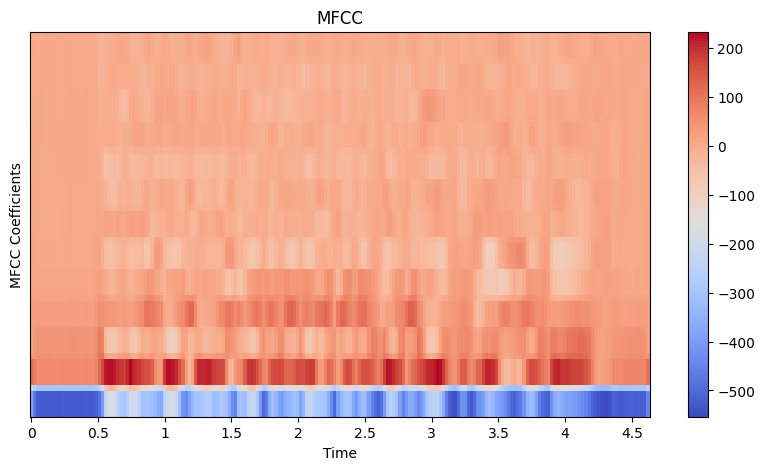

In [13]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfcc_spec[1], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [307]:
X = np.array(mfcc_spec)
y= data.loc[:, 'Emotions']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['sad', 'fear', 'anger', 'disgust', 'neutral', 'surprised', 'happy','calm'])
y_transformed=le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [308]:
X_reshaped = X_train.reshape(5617, 60*200)
X_val_reshaped = X_val.reshape(1872, 60*200)
X_test_reshaped = X_test.reshape(1873, 60*200)

In [309]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_reshaped)
X_reshaped = scaler.transform(X_reshaped)
X_val_reshaped = scaler.transform(X_val_reshaped)
X_test_reshaped = scaler.transform(X_test_reshaped)

In [310]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5617, 60, 200)
(1872, 60, 200)
(1873, 60, 200)


In [311]:
k_list = []
scores_list = [] 
 
for k in range(1,50):
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="euclidean")
        knn.fit(X_reshaped,y_train)
        y_pred=knn.predict(np.array(X_test_reshaped)) 
        k_list.append(k)
        accuracy = metrics.accuracy_score(y_test,y_pred)
        print(k, 'accuracy',accuracy)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

1 accuracy 0.3598505072076882
2 accuracy 0.3598505072076882
3 accuracy 0.37213027229044315
4 accuracy 0.3635878270154832
5 accuracy 0.3571809930592632
6 accuracy 0.3609183128670582
7 accuracy 0.37800320341697813
8 accuracy 0.3849439402028831
9 accuracy 0.38601174586225306
10 accuracy 0.38120662039508807
11 accuracy 0.38601174586225306
12 accuracy 0.3817405232247731
13 accuracy 0.3865456486919381
14 accuracy 0.38868126001067804
15 accuracy 0.3833422317138281
16 accuracy 0.3758675920982381
17 accuracy 0.3849439402028831
18 accuracy 0.3806727175654031
19 accuracy 0.37533368926855315
20 accuracy 0.3694607581420182
21 accuracy 0.3742658836091831
22 accuracy 0.37319807794981313
23 accuracy 0.3758675920982381
24 accuracy 0.3726641751201281
25 accuracy 0.3678590496529632
26 accuracy 0.36572343833422316
27 accuracy 0.3635878270154832
28 accuracy 0.36252002135611316
29 accuracy 0.36252002135611316
30 accuracy 0.36252002135611316
31 accuracy 0.36412172984516816
32 accuracy 0.3614522156967432
33 a

In [312]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
dtc.fit(X_reshaped, y_train)
y_pred = dtc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.3198077949813134


In [313]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_reshaped, y_train)
y_pred = rfc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.4586225306994127


In [314]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(60, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [315]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_val,y_val))

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.2375 - loss: 8.3506 - val_accuracy: 0.3809 - val_loss: 1.5524
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.3937 - loss: 1.5493 - val_accuracy: 0.3974 - val_loss: 1.4795
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 575ms/step - accuracy: 0.4696 - loss: 1.3735 - val_accuracy: 0.4354 - val_loss: 1.4499
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.5261 - loss: 1.2315 - val_accuracy: 0.4418 - val_loss: 1.4689
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5840 - loss: 1.1010 - val_accuracy: 0.4444 - val_loss: 1.4780


In [316]:
model.evaluate(X_test, y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4682 - loss: 1.4363


[1.4372069835662842, 0.4602242410182953]

In [317]:
from sklearn import svm

model=svm.SVC()
model.fit(X_reshaped,y_train)

SVC()

In [318]:
y_pred = model.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.5130806193272824
